In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__, keras.__version__)

2.3.1 2.4.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape, X_test.shape)

X_train, X_valid  = X_train_full[5000:], X_train_full[:5000]
y_train, y_valid  = y_train_full[5000:], y_train_full[:5000]

print(X_train.shape, X_valid.shape)

class_names = ["T-shirt/pop", "Trouser", "Pullover", "Dresss", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

(60000, 28, 28) (10000, 28, 28)
(55000, 28, 28) (5000, 28, 28)


## Vanishing and Explidng Gradients

As the chain rule requires product of all gradients, $f'(g(x)) = f'(g) \times g'(x)$ For deep networks when the gradients are very below 0, then the gradients of the lower layers becomes extremely small (<<1) and training will never converge. Conversely when the gradients are large (>>1), the training gradients becomes very large and the training diverges.

This in general is called **unstable gradients** problem.

Good video here: https://www.youtube.com/watch?v=8krd5qKVw-Q&t=88s

### Data Prep

### Initialisation

**Glorot and He** proposed to ensure the signal to flow properly by ensuring variables of the output from each layer to be equal to the variance of its inputs and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. Its actually not possible to guarantee this. The comprimise that has proven to work very well in practice, is to initialise the connection weights randomely based on a strategy. (See page 333 of the ML book)

| Initialisation | Activation Function | Variance      |
|----------------|---------------------|---------------|
| Glorot         | sigmoid, tahn       | 1/fan_{avg} |
| He             | ReLu and variants   | 2/fan_{in}  |
| LeCun          | SELU                | 1/fan_{in}  |

By default Keras use Glorot initialisation with a uniform distribution. When creating a laery you can change this to He initialisation.

See above as an example

### Nonsaturation Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was the problem with unstable gradients were in part due to poor choice of activations. Compared to saturating functions such as sigmoid or tanh, ReLU was used following the discovery that it behaves much better in deep neural networks. Before then sigmoid or tanh were used as it approximates *nature*. 


**Dying Neurons**
ReLU function is not *perfect*. It suffers from a problem called *dying neurons* where some neurons will efectives stop outputting anything but 0, and gradient descent will no longer be effective and gradient at 0 will be 0.

To solve this isssue, there are multiple variations of ReLus.

- leakey Relu (where there is a small coeficient $\alpha$ after 0
- RReLu (Random Relu where $\alpha$ is picked at random. also can act as a regularisor
- PReLu. where $\alpha$ is learned during training. (instead of being a hyper parameter, it is becomes a parameter that can be modified by backpropagation.
- ELU (exponential linear unit) that can out perform others, but can be slow
- SELU (Scale ELU) is introduce in 2017. For neuronetwork composed exclusively stacked dense layers. SELI activation function will allow the network to *self-normalise*. (the output layer will tend to preserve a mean of 0 and standard diviation of 1 during training). The condtions being:
    - Input features must be standardised
    - every hiddern layer weights must be initialised with lecun_normal
    - network architecture must be sequential
    - all layers are dense
    
    
typically SELU > ELU > Leaky ReLu (and viants) > RuLu > tahnh > sigmoid

No handles with labels found to put in legend.


-0.6321205588285577


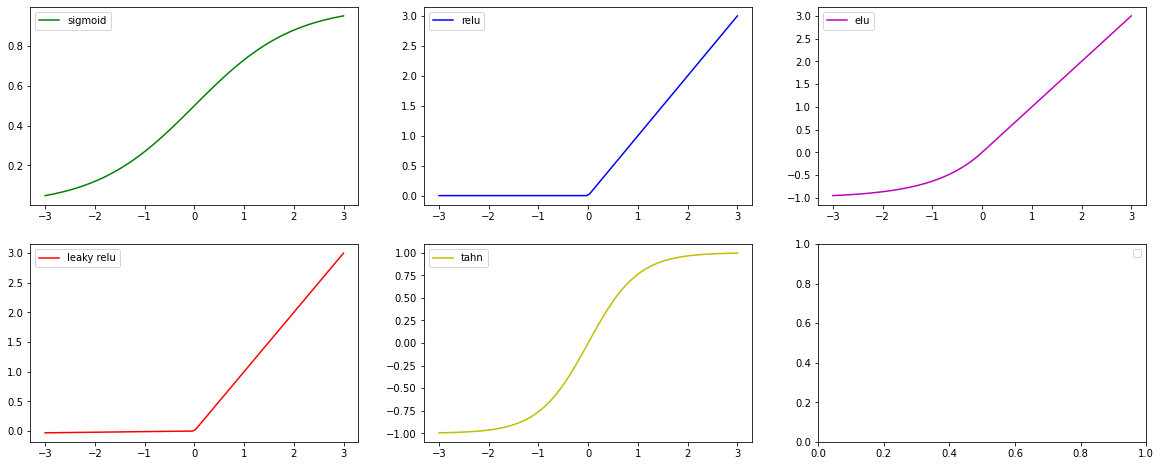

In [12]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(-3, 3, 100)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    if x > 0:
        return x
    else:
        return 0

# 0.01 is small leak, 0.2 is huge leak
def leaky_relu(x, alpha = 0.01):
    return x if x > 0 else alpha * x


def elu(x, alpha=0.1):
    if x >= 0:
        return x
    else:
        return alpha * (np.exp(x) - 1)

print(elu(-1, 1))

v_sigmoid = np.vectorize(sigmoid)
v_relu = np.vectorize(relu)
v_leaky_relu = np.vectorize(leaky_relu)
v_elu = np.vectorize(elu)

s = v_sigmoid(x)
r = [relu(v) for v in x]
lr = v_leaky_relu(x)
tanh = np.tanh(x)
elu = [elu(v, 1) for v in x]

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 8)
ax[0][0].plot(x, s, c = 'g', label = "sigmoid")
ax[0][1].plot(x, r, c = 'b', label = "relu")
ax[0][2].plot(x, elu, c = 'm', label = "elu")
ax[1][0].plot(x, lr, c = 'r', label = "leaky relu")
ax[1][1].plot(x, tanh, c = 'y', label = "tahn")

for i in range(2):
    for j in range(3):
        ax[i][j].legend()

### Batch Normalisation

Using a combination of He initialisation and ELU (or variants of ReLU) can significantly reduce gradient unstability at beginning of the training, but does not guarantee the issue won't come back during training.

**Batch Normalisation** can be used to address the problem. The technique involves adding another layer before or after activation for each of hidden layers, that zero-centres and normalises (scales) each input.

In many cases we can add a BN layer before in the very first layer then normaliastion is not required.

It estimates mean and standard deviation of each mini batch.

1. Calculate mean:

    $\mu_\beta = \frac{1}{m_\beta}\sum_{i = 1}^{m_\beta}x_{(i)}$

2. Calcualte variance:

    $\sigma_\beta^2 = \frac{1}{m_\beta}\sum_{i = 1}^{m_\beta}(x^{(i)} - \mu_\beta)^2$

3. Vector of zero-centred and normalised input for instance i. $\epsilon$ is a tiny number to avoid divid by zero.

    $\hat{x}^{(i)} = \frac{x^{(i)} - \mu_\beta}{\sqrt{\sigma_\beta^2 + \epsilon}}$

4. $z^{(i)}$ is the output of the BN operation. It is a rescaled version of the inputs $\gamma$ is the output scale parameter vector for the layer (one sclare per input). $\otimes$ is element-wise multiplication. $\beta$ is offset parameter vector, one for each input.

    $z^{(i)} = \gamma \otimes \hat{x}^{(i)} + \beta$
    
    
During training, BN standardises input, then rescales and offsets them:
    - Both $\beta$ and $\gamma$ are attributes that are trained.
    - The mean $\mu$ and standard deviation $\sigma$ are estimated using exponential moving average
    
    
From Andrew Ng:
https://www.youtube.com/watch?v=nUUqwaxLnWs


Finanally, Batch_Normalisation acts like a regularizer and reduce the needs of others (such as drop out)

### Build Model

In [15]:
from tensorflow.keras import activations, layers, initializers, callbacks, models
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, ELU

# This is use for customise default
he_avg_init = initializers.VarianceScaling(scale = 2, mode = "fan_avg", distribution = "uniform")

model = models.Sequential([
        layers.Flatten(input_shape=[28, 28]),
        BatchNormalization(), # note the number of params is 3136 (784 * 4). This is the scaling, offset, mean, std dev, mentioned above
                              # as it is already normalised, the preprocessing part in the beginning is not required
        # using ELU activation
        layers.Dense(256, kernel_initializer = "he_normal"), #use He normal distribution
        layers.ELU(),
        BatchNormalization(), 
        # using LeakyReLU activation
        layers.Dense(128, activation = "relu", kernel_initializer = he_avg_init),
        layers.LeakyReLU(alpha = 0.2),
        BatchNormalization(), 
        layers.Dense(10, activation = "softmax")
])

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 784)               3136      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               200960    
_________________________________________________________________
elu (ELU)                    (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)              

In [16]:
NUM_EPOCHS = 30
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid), verbose = True)

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5621 - accuracy: 0.8046 - val_loss: 0.4187 - val_accuracy: 0.8630
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4234 - accuracy: 0.8505 - val_loss: 0.3784 - val_accuracy: 0.8732
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3786 - accuracy: 0.8631 - val_loss: 0.3921 - val_accuracy: 0.8762
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3586 - accuracy: 0.8712 - val_loss: 0.3618 - val_accuracy: 0.8792
Epoch 5/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3419 - accuracy: 0.8763 - val_loss: 0.3575 - val_accuracy: 0.8788
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3233 - accuracy: 0.8839 - val_loss: 0.3497 - val_accuracy: 0.8858
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3088 - accuracy: 0.8877 - val_loss: 0.4376 - val_accuracy:

### History Object

Fit function returns a history object

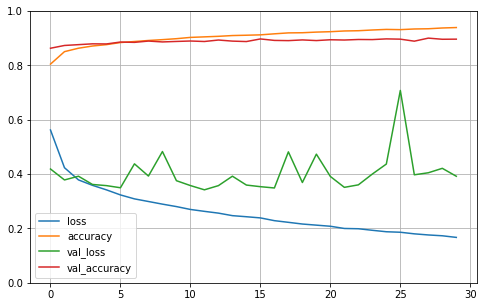

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [18]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4006 - accuracy: 0.8861


[0.4005756080150604, 0.8860999941825867]

## Making Predictions


In [19]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [20]:
import numpy as np

#model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_test[:3]), axis = -1)
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')